In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error
from datetime import datetime
plt.style.use('fivethirtyeight')

In [ ]:
# Fetch Bitcoin historical data from Yahoo Finance
ticker = "BTC-USD"
end=datetime.now() # current date
start = datetime(end.year-15,end.month,end.day) # 15 years before the current date
data = yf.download(ticker, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [ ]:
data

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...
2025-04-21,87518.906250,88460.093750,85143.835938,85171.539062,41396190190
2025-04-22,93441.890625,93817.382812,87084.531250,87521.875000,55899038456


In [ ]:
data = data[['Close']]
data = data.dropna()

In [ ]:
data

Price,Close
Ticker,BTC-USD
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2025-04-21,87518.906250
2025-04-22,93441.890625


In [ ]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [ ]:
# Split the data into training and testing sets
time_step = 60
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

In [ ]:
# Reshape data for LSTM/GRU/RNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Function to build models
def build_model(model_type='LSTM'):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(50, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
        model.add(Dropout(0.2))
        model.add(GRU(50, return_sequences=False))
    elif model_type == 'RNN':  # Added RNN model
        model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
        model.add(Dropout(0.2))
        model.add(SimpleRNN(50, return_sequences=False))

    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Train and evaluate LSTM model
lstm_model = build_model('LSTM')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0054 - val_loss: 0.0011
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.8168e-04 - val_loss: 9.3753e-04
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.4777e-04 - val_loss: 0.0018
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.9668e-04 - val_loss: 8.7272e-04
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5033e-04 - val_loss: 0.0027
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1111e-04 - val_loss: 8.0750e-04
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.6498e-04 - val_loss: 7.3454e-04
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.1235e-04 - val_loss: 6.2488e-04
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.4723e-04 - val_loss: 6.0127e-04
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.8640e-04 - val_loss: 0.0025
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.0303e-04 - val_loss: 0.0011
Epoch 12/5

In [ ]:
# Train and evaluate GRU model
gru_model = build_model('GRU')
gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0054 - val_loss: 5.2259e-04
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7345e-04 - val_loss: 4.9880e-04
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.9976e-04 - val_loss: 5.9825e-04
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.7804e-04 - val_loss: 0.0012
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.9589e-04 - val_loss: 0.0016
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2716e-04 - val_loss: 4.2500e-04
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.4661e-04 - val_loss: 5.5017e-04
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.4586e-04 - val_loss: 8.1628e-04
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1301e-04 - val_loss: 3.6238e-04
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9246e-04 - val_loss: 7.6907e-04
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8288e-04 - val_loss: 

In [ ]:
# Train and evaluate RNN model  # Added RNN model training
rnn_model = build_model('RNN')
rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0648 - val_loss: 0.0074
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0055 - val_loss: 0.0037
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030 - val_loss: 0.0059
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.6287e-04 - val_loss: 0.0018
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.5764e-04 - val_loss: 0.0040
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.8043e-04 - val_loss: 0.0014
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.3832e-04 - val_loss: 0.0018
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0605e-04 - val_loss: 0.0013
Epoch 12/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 1

In [ ]:
# Function to predict and evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
    print(f'RMSE for {model_name}:', rmse)
    return predictions, rmse

In [ ]:
# Evaluate models
lstm_predictions, lstm_rmse = evaluate_model(lstm_model, X_test, y_test, 'LSTM')
gru_predictions, gru_rmse = evaluate_model(gru_model, X_test, y_test, 'GRU')
rnn_predictions, rnn_rmse = evaluate_model(rnn_model, X_test, y_test, 'RNN')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE for LSTM: 1907.1581107600477
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
RMSE for GRU: 2599.4906876656128
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
RMSE for RNN: 2580.13280722563


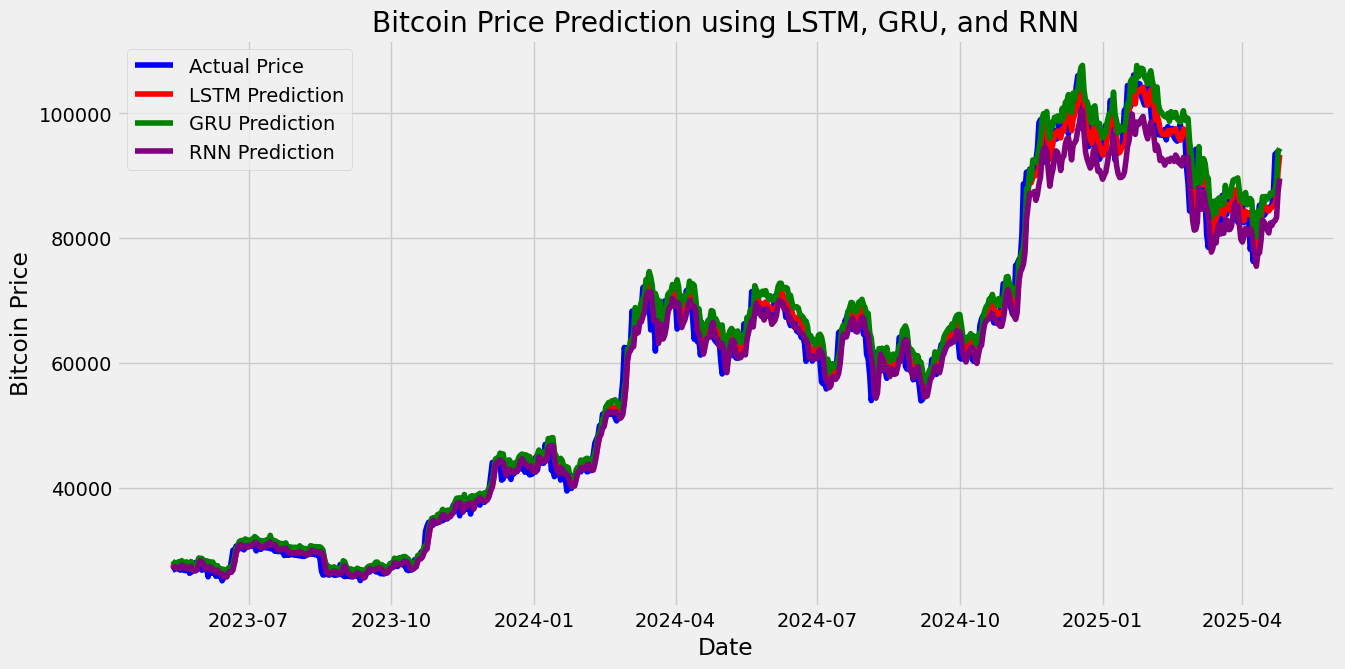

In [ ]:

# Plot predictions
plt.figure(figsize=(14, 7))
plt.plot(data.index[train_size + time_step + 1:], scaler.inverse_transform(test_data[time_step+1:]), label='Actual Price', color='blue')
plt.plot(data.index[train_size + time_step + 1:], lstm_predictions, label='LSTM Prediction', color='red')
plt.plot(data.index[train_size + time_step + 1:], gru_predictions, label='GRU Prediction', color='green')
plt.plot(data.index[train_size + time_step + 1:], rnn_predictions, label='RNN Prediction', color='purple')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.title('Bitcoin Price Prediction using LSTM, GRU, and RNN')
plt.show()

In [ ]:
# Predict future prices
future_days = 30
future_predictions = {}

for model_name, model in zip(['LSTM', 'GRU', 'RNN'], [lstm_model, gru_model, rnn_model]):
    last_sequence = data_scaled[-time_step:].reshape(1, time_step, 1)
    future_prices = []
    for _ in range(future_days):
        predicted_price = model.predict(last_sequence)[0][0]
        future_prices.append(predicted_price)
        last_sequence = np.append(last_sequence[:, 1:, :], [[[predicted_price]]], axis=1)
    future_predictions[model_name] = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))
    print(f'Future {future_days}-day predictions using {model_name}:')
    print(future_predictions[model_name].flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

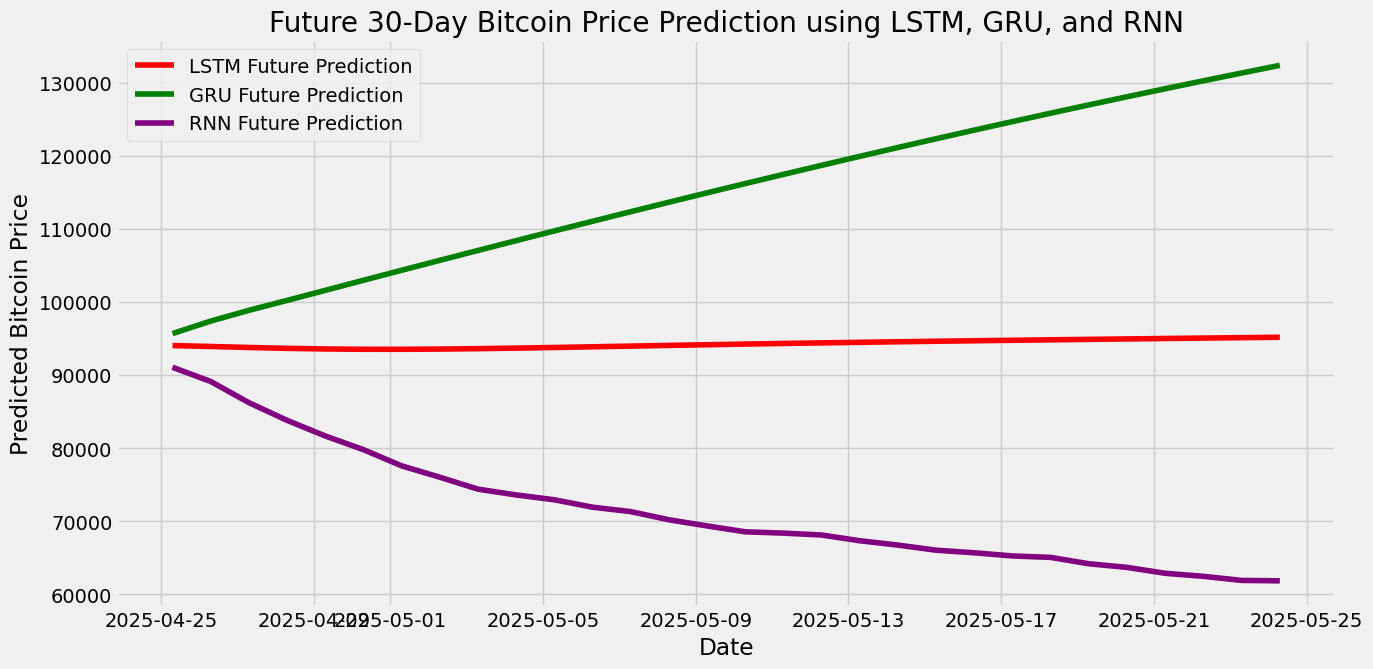

In [ ]:
# Plot future predictions
plt.figure(figsize=(14, 7))
dates = pd.date_range(start=end, periods=future_days)

plt.plot(dates, future_predictions['LSTM'], label='LSTM Future Prediction', color='red')
plt.plot(dates, future_predictions['GRU'], label='GRU Future Prediction', color='green')
plt.plot(dates, future_predictions['RNN'], label='RNN Future Prediction', color='purple')

plt.xlabel('Date')
plt.ylabel('Predicted Bitcoin Price')
plt.legend()
plt.title('Future 30-Day Bitcoin Price Prediction using LSTM, GRU, and RNN')
plt.show()

In [ ]:
lstm_model.save("crypto_model.keras")